<a href="https://colab.research.google.com/github/anniewit/ML/blob/master/DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Osnabrück University - Machine Learning (Summer Term 2019) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 03: Basics of Data Mining

<IPython.core.display.Javascript object>


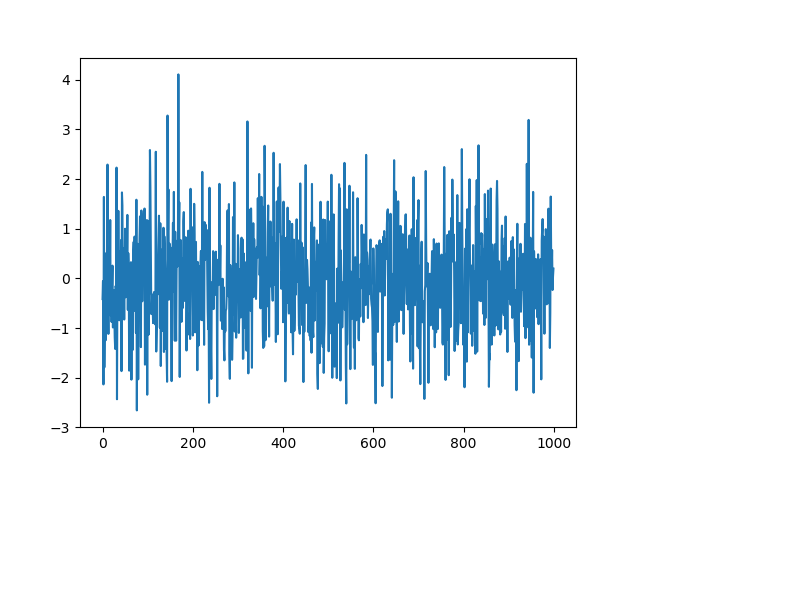

In [0]:
%matplotlib notebook
import importlib

assert importlib.util.find_spec('numpy') is not None , 'numpy not found'
assert importlib.util.find_spec('matplotlib') is not None, 'matplotlib not found'

import numpy as np
import matplotlib.pyplot as plt

figure_intro = plt.figure('Example plot')
plt.plot(np.random.randn(1000, 1))
figure_intro.canvas.draw()

## Rosner test
The Rosner test is an iterative procedure to remove outliers of a data set via a z-test. In this exercise you will implement it and apply it to a sample data set.


`data` is a `np.array` of `[x, y]` coordinates. `outliers` is a list of `[x, y]` coordinates.

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# generate dataset
data = list(zip(np.random.uniform(size=100), np.random.normal(size=100)))
data += list(zip(np.random.uniform(size=10), np.random.normal(0, 10, size=10)))
data = np.array(data)
outliers = []

# just to check if everything is pretty
fig_rosner_data = plt.figure('The Dataset')
plt.scatter(data[:,0], data[:,1], marker='x')
plt.axis([0, 1, -20, 20])
fig_rosner_data.canvas.draw()

# Now find the outliers, add them to 'outliers', and remove them from 'data'.
# y-values into array
y_values = data[:,1]
# calculate mean and standard deviation
mean = np.mean(y_values)
std = np.std(y_values)

# z-transform 
z = np.arange(len(y_values))
z = []

# list of absolute z-values 
for yi in y_values:    
    z.append(np.abs((yi - mean)) / std)
    

while True: 
    # find data point with largest z-value
    max_z = np.amax(z)
    
    # check abbruchbedingung
    if max_z < 3:
        break
        
    max_index = np.where(z == max_z)
    max_index = max_index[0][0]  
    
    # get coordinates of max value
    max_x = data[max_index][0]
    max_y = data[max_index][1]
    
    #mark as outliers and remove from list
    outliers.append([max_x, max_y])
    z.remove(max_z)
    np.delete(data,max_index,0)
    

# plot results
outliers = np.array(outliers)
fig_rosner = plt.figure('Rosner Result')
plt.scatter(data[:,0], data[:,1], c='b', marker='x', label='cleared data')
plt.scatter(outliers[:,0], outliers[:,1], c='r', marker='x', label='outliers')
plt.axis([0, 1, -20, 20])
plt.legend(loc='lower right');
fig_rosner.canvas.draw()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Expectation Maximization

The approach of the EM algorithm is that the hidden values can be approximated by  probability distribution, which however also contains the unknown parameters of the distribution. The EM algorithm thus iteratively tries to estimate the parameters $\theta$ of the distribution (by maximizing the log-likelihood) (M-step) and using these parameters to average over the hidden values (E-step).
The EM algorithm thus tries to replace missing values according to a probabilistic model.

Applications:
* Replace missing values
* soft clustering


In [0]:
import numpy as np

def load_data(file_name):
    """
    Loads the data stored in file_name into a numpy array.
    """
    result = None
    result = np.loadtxt(file_name)
    return result

  
assert load_data('em_normdistdata.txt').shape == (200,) , "The data was not properly loaded."

<IPython.core.display.Javascript object>


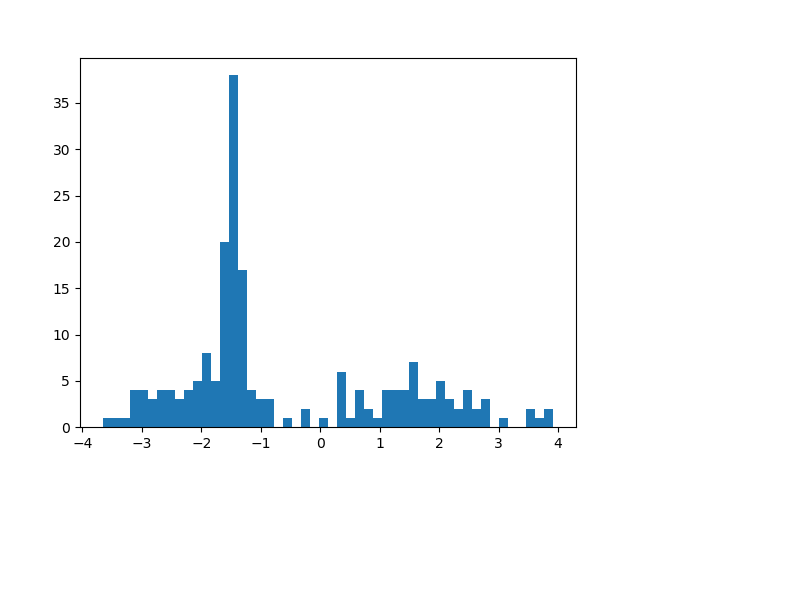

In [0]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

data = load_data('em_normdistdata.txt')

fig_data_test = plt.figure('Data overview')
plt.hist(data, bins=50)
fig_data_test.canvas.draw()

<IPython.core.display.Javascript object>


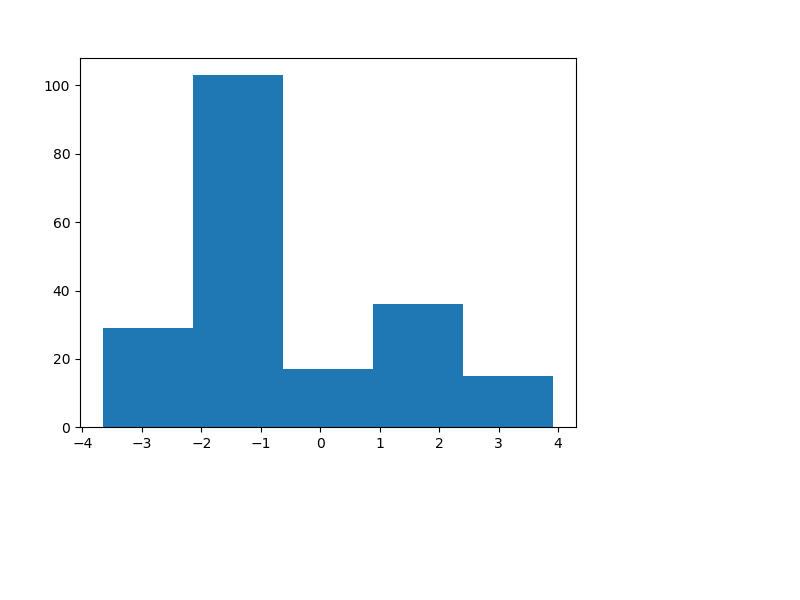

In [0]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

data = load_data('em_normdistdata.txt')

fig_data_test = plt.figure('Data overview')
plt.hist(data, bins=5)
fig_data_test.canvas.draw()

#### Step 2) Initialize EM

Below is a class definition `NormPDF` which represents the probability density function (pdf) of the normal distribution with an additional parameter $\alpha$. The class is explained in the next cells.

In [0]:
import numpy as np
class NormPDF():
    """
    A representation of the probability density function of the normal distribution
    for the EM Algorithm.
    """

    def __init__(self, mu=0, sigma=1, alpha=1):
        """
        Initializes the normal distribution with mu, sigma and alpha.
        The defaults are 0, 1, and 1 respectively.
        """
        self.mu = mu
        self.sigma = sigma
        self.alpha = alpha


    def __call__(self, x):
        """
        Returns the evaluation of this normal distribution at x.
        Does not take alpha into account!
        """
        return np.exp(-(x - self.mu) ** 2 / (2 * self.sigma ** 2)) / (np.sqrt(np.pi * 2) * self.sigma)


    def __repr__(self):
        """
        A simple string representation of this instance.
        """
        return 'NormPDF({self.mu:.2f},{self.sigma:.2f},{self.alpha:.2f})'.format(self=self)

In [0]:
def initialize_EM(data, num_distributions):
    """
    Initializes the EM algorithm by calculating num_distributions NormPDFs
    from a random partitioning of data. I.e., the data set is randomly
    divided into num_distribution parts, and each part is used to initialize
    mean, standard deviation and alpha parameter of a NormPDF object.
    
    Args:
        data (array): A collection of data.
        num_distributions (int): The number of distributions to return.
        
    Returns:
        A list of num_distribution NormPDF objects, initialized from a
        random partioning of the data.
    """
    gaussians = []
    chunk_size = int(len(data) / num_distributions)

    # shuffle data
    np.random.shuffle(data)
    
    # partition data into n chunks
    chunks = []
    for i in range(num_distributions):
        batch = []
        for element in data[i:len(data):num_distributions]:
            batch.append(element)
        chunks.append(batch)
    
    # calculate parameters for each chunk, initialize normpdf
    for chunk in chunks:
        mean = np.mean(chunk)
        std = np.std(chunk)
        alpha = len(chunk)/len(data)
        normpdf = NormPDF(mean, std, alpha)
        gaussians.append(normpdf)
    
    return gaussians


normpdfs_ = initialize_EM(np.linspace(-1, 1, 100), 2)
assert len(normpdfs_) == 2, "The number of initialized distributions is not correct."
# 1e-10 is 0.0000000001
assert abs(1 - sum([normpdf.alpha for normpdf in normpdfs_])) < 1e-10 , "Sum of all alphas is not 1.0!"

#### Step 3) Implement the expectation step

Performs a soft classification of the data samples with the normal distributions. Calculates the likelihood that a data sample $x_i$ belongs to distribution $j$ given parameters $\mu_j$ and $\sigma_j$. Or in other words, what is the likelihood of $x_i$ to be drawn from $N_j(\mu_j, \sigma_j)$? When you got the likelihood, weight the result by $\alpha_j$.

As a last step normalize the results such that the likelihoods of a data sample $x_i$ sum up to $1$.


In [0]:
def expectation_step(gaussians, data):
    """
    Performs the expectation step of the EM.
    
    Args:
        gaussians (list): A list of NormPDF objects.
        data (array): The data vector.
        
    Returns:
        An array of shape (len(data), len(gaussians))
        which contains normalized likelihoods for each sample
        to denote to which of the normal distributions it 
        most likely belongs to.
    """
    expectation = None
    
    l = np.zeros((len(data),len(gaussians)))  
    # write Likelihood for data to belong to gaussian g in column c. 
    for c,gaus in enumerate(gaussians):
        l[:,c] = gaus(data) 

    # Normalize the lieklihoods such that each row of l sums to 1
    normalized =  np.zeros((len(data),len(gaussians)))  
    for i in range(len(l)):
        normalized[i] = l[i]/np.sum(l,axis=1)[i] 
        
    expectation = normalized

    return expectation
    

assert expectation_step([NormPDF(), NormPDF(2,3,4)], np.linspace(-2, 2, 100)).shape == (100, 2) , "Shape is not correct!"

#### Step 4) Implement the maximization step

In the maximization step each $\mu_j$, $\sigma_j$ and $\alpha_j$ is updated. First calculate the new means:

$$\mu_j = \frac{1}{\sum\limits_{i=1}^{|X|} p_{ij}} \sum\limits_{i=1}^{|X|} p_{ij}x_i$$

That means $\mu_j$ is the weighted mean of all samples, where the weight is their likelihood of belonging to distribution $j$.

Then calculate the new $\sigma_j$. Each new $\sigma_j$ is the standard deviation of the normal distribution with the new $\mu_j$, so for the calculation you already use the new $\mu_j$:

$$\sigma_j = \sqrt{ \frac{1}{\sum\limits_{i=1}^{|X|} p_{ij}} \sum\limits_{i=1}^{|X|} p_{ij} \left(x_i - \mu_j\right)^2 }$$

To calculate the new $\alpha_j$ for each distribution, just take the mean of $p_j$ for each normal distribution $j$.

**Caution:** For the next step it is necessary to know how much all $\mu$ and $\sigma$ changed. For that the function `maximization_step` should return a numpy array of those (absolute) changes. For example if $\mu_0$ changed from 0.1 to 0.15, $\sigma_0$ from 1 to 0.9, $\mu_1$ from 0.5 to 0.6, and $\sigma_1$, $\mu_2$, and $\sigma_2$ stayed the same, we expect the function to return `np.array([0.05, 0.1, 0.1, 0, 0, 0])` (however, the order is not important).

In [0]:
def maximization_step(gaussians, data, expectation):
    """
    Performs the maximization step of the EM.
    Modifies the gaussians by updating their mus and sigmas.
    
    Args:
        gaussians (list): A list of NormPDF objects.
        data (array): The data vector.
        expectation (array): The expectation values for data element
            (as computed by expectation_step()).

    Returns:
        A numpy array of absolute changes in any mu or sigma, 
        that means the returned array has twice as many elements as
        the supplied list of gaussians.
    """
    changes = []
    for i, gauss in enumerate(gaussians):
        #extract 1 column of the expectation (for the corresponding dist)
        prob_j = [row[i] for row in expectation]
        # sum up probabilities
        sum_p = np.sum(prob_j)
        
        # formula for mean j
        mean = (1/sum_p) * np.sum([xi * pi for xi, pi in zip(data, prob_j)]) 
        
        std = np.sqrt((1/sum_p) * np.sum([pi * (xi - mean)**2 for xi, pi in zip(data, prob_j)]))
        
        alpha = np.mean(prob_j)
        
        old_mean = gauss.mu
        old_std = gauss.sigma
        old_alpha = gauss.alpha
        
        changes += [abs(old_mean - mean), abs(old_std - std), abs(old_alpha - alpha)] 
    
    
    return np.array(changes)

**5) Perform the complete EM and plot your results:**

Initialize three normal distributions whose parameters will be changed iteratively by the EM to converge close to the original distributions.

Build a loop around the iterative procedure of expectation and maximization which stops when the changes in all $\mu_j$ and $\sigma_j$ are sufficiently small enough.

Plot your results after each step and mark which data points belong to which normal distribution. If you don't get it to work, just plot your final solution.

*Hint:* Remember to load the data and initialize the EM before the loop.

*Hint:* A function `plot_intermediate_result` to plot your result after each step is already defined in the next cell. Take a look at what arguments it takes and try to use it in your loop.

*Hint:* To plot your final result the first three images and corresponding code examples on the tutorial of [`plt.plot(...)`](http://matplotlib.org/users/pyplot_tutorial.html) should help you.

*Optional:* Run the code multiple times. If your results are changing, use `np.random.seed(2)` in the beginning of the cell to get consistent results (any other integer will work as well, but 2 has some good results for the example solutions).

In [0]:
%matplotlib notebook
import time
import itertools

import numpy as np
import matplotlib.pyplot as plt
# Sets the random seed to a fix value to make results consistent
np.random.seed(2)

colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y', 'k'])
figure, axis = plt.subplots(1)
axis.set_xlim(-5, 5)
axis.set_ylim(-0.2, 4)
axis.set_title('Intermediate Results')
plt.figure('Final Result')

def plot_intermediate_result(gaussians, data, mapping):
    """
    Gets a list of gaussians and data input. The mapping
    parameter is a list of indices of gaussians. Each value
    corresponds to the data value at the same position and 
    maps this data value to the proper gaussian.
    """
    x = np.linspace(-5, 5, 100)
    if len(axis.lines):
        for j, N in enumerate(gaussians):
            axis.lines[j * 2].set_xdata(x)
            axis.lines[j * 2].set_ydata(N(x))
            axis.lines[j * 2 + 1].set_xdata(data[mapping == j])
            axis.lines[j * 2 + 1].set_ydata([0] * len(data[mapping == j]))
    else:
        for j, N in enumerate(gaussians):
            axis.plot(x, N(x), data[mapping == j], [0] * len(data[mapping == j]), 'x', color=next(colors), markersize=5)
    figure.canvas.draw()
    time.sleep(0.5)

    
# Perform the initialization.
data = load_data('em_normdistdata.txt')
gaussians = initialize_EM(data, 3)

# Loop until the changes are small enough.
eps = 0.05
changes = [float('inf')] * 2
while max(changes) > eps:
    # Iteratively apply the expectation step, followed by the maximization step.
    
    expectation = expectation_step(gaussians, data)
    changes = maximization_step(gaussians, data, expectation)

    # Optional: Calculate the parameters to update the plot and call the function to do it.
    plot_intermediate_result(gaussians, data, np.argmax(expectation, 1))


# Plot final result and print the final parameters.
x = np.linspace(-5, 5, 1000)
for N in gaussians:
    axis2.plot(x, N(x), color=next(colors))
plt.show()
